# An extension of the Newman-Ziff algorithm for studying repeated percolation processes  

## Overview

TBD...

## The Newman-Ziff algorithm

We begin with a **base network** $G = (N, E)$, and want to explore the percolation behaviour of this network for some probability $T$ that an edge in the base network is **occupied**. For a given value of $T$ we independently occupy each edge with probability $T$ or leave it unoccupied with probability $(1 - T)$. The set of occupied edges $E_T$ induces a set of occupied nodes $N_T$ which is the sub-set of nodes from $N$  upon which at least one edge from $E_T$ is incident. Taken together these two sets form the **occupied network at $T$** $O_T = (N_T, E_T)$. Note that percolation is a stochastic process, so $O$ is a member of the ensemble of all networks formed by occupying some fraction $T$ of the edges in $E$.

One might think that in order to study a range of values of $T$ it would be necessary to repeat the perecolation process anew on $B$ each time. The Newman-Ziff (NZ) algorithm simplifies this process by constructing $O_T$ for all values of $T$ in a single sweep through $E$. It works on the observation that $O_0 = (\emptyset, \emptyset)$, the empty network, while $O_1 = G$. Let $M = |E|$ denote the number oif edges in $G$. We select a single edge at random from $E$ and occupy it to form $O_\frac{1}{M}$ consisting of two nodes connected by that edge (assuming no self-loops). This network is a valid member of the ensemble of networks consisting of a single edge taken from $E$, formed with an occupation probability $T = \frac{1}{M}$. If we select another edge randomly from $E$ and occupy it, adding it (and its incident nodes) to $O_\frac{1}{M}$, we form the network $O_\frac{2}{M}$, and so forth until all edges in $E$ have been occupied, forming the network $O_1$. Each $O_T$ is one possible realisation of the percolation process for occupation probability $T$.

Clearly it is wasteful to hold the sequence of $O_T$, and NZ insteads creates them in sequence, keeping track of any properties of interest along the way. The most basic proerty is the size of the largest connected component (LCC) in each $O_T$, which will become a giant connected component (GCC) above the critical percolation threshold $T_c$. (For simplicity we usually refer to "the GCC" even in the sub-critical domain.) This computation requires that all nodes are labelled to identify the component to which they belong, where initially every node is a component of size 1 consisting of itself alone. Occupying edges connects components together to form larger components, which requires re-labelling the nodes of one to have the label of the other. NZ adopts a novel encoding of nodes and components to allow this process (called "union-find" in the computer science literature) to happen efficiently. 

In [6]:
from epyc import Lab, Experiment, ResultsDict
from epydemic import Node, Edge, NetworkExperiment, ERNetwork, PLCNetwork
from networkx import Graph, read_adjlist
import numpy

from typing import Any, Dict, Union, Iterable, List, Final, Optional, cast

# display and interaction
from IPython.display import display, Math
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
import dash_core_components as dcc
import dash_html_components as html

In [53]:
class NewmanZiff(NetworkExperiment):
    '''Base class for the Newman-Ziff site and bond percolation algorithm.
    
    :param g: (optional) the underlying network or generator
    :param samples: (optional) number of samples or list of sample points (defaults to 100)'''

    def __init__(self, g : Graph =None, samples : Union[int, Iterable[float]] =None):
        super(NewmanZiff, self).__init__(g)

        # fill in default
        if samples is None:
            samples = 100
        if isinstance(samples, int):
            samples = numpy.linspace(0.0, 1.0, num=samples, endpoint=True)
        self._samples : List[float] = sorted(numpy.unique(list(cast(Iterable[float], samples))))

        # components data structure is initially empty
        self._components : numpy.ndarray = None

        # no component
        self._gcc = 0

    def tearDown(self):
        '''Throw away the components data structure at tear-down.'''
        self._components = None
        super(NewmanZiff, self).tearDown()

    def report(self, params : Dict[str, Any], meta : Dict[str, Any], res : List[Dict[str, Any]]) -> List[ResultsDict]:
        '''Re-write the list of results into a list of individual experiments by
        wrapping them up as results dicts. Essentially this presents the results as though
        a percolation experiment had happened for each sample.

        :param params: the experimental parameters
        :param meta: the metadata
        :param res: a list of individual sample results
        :returns: a list of results dicts'''
        rcs = []
        for r in res:
            # wrap the experiment results in their own results dict
            rc = self.resultsdict()
            rc[self.PARAMETERS] = params.copy()
            rc[self.METADATA] = meta.copy()
            rc[self.RESULTS] = r.copy()
            rcs.append(rc)
        return rcs

In [54]:
class BondPercolation(NewmanZiff):
    '''A bond (edge) percolation experiment. This experiment computes the size of
    the giant connected component (GCC) as edges are "occupied" within the underlying network.
    It samples the GCC at a given sequence of occupation probabilities, returning
    a time series of the growth of the GCC.

    :param g: (optional) the underlying network or generator
    :param samples: (optional) number of samples or list of sample points (defaults to 100)'''

    # Synthesised parameters
    P : Final[str] = 'epydemic.bondpercolation.pOccupied'    #: Parameter holding percolation threshold.

    # Experimental results
    GCC : Final[str] = 'epydemic.bondpercolation.gcc'        #: Result holding size of GCC.

    def __init__(self, g : Graph =None, samples : Union[int, Iterable[float]] =None):
        super(BondPercolation, self).__init__(g, samples)

    def setUp(self, params : Dict[str, Any]):
        '''Set up the process, creating the initial components data structure from the
        underlying network.

        :param params: the experimental parameters'''
        super(BondPercolation, self).setUp(params)
        self._components = numpy.full(N, -1, numpy.int32)
        self._gcc = 1   # initially all nodes are individual components, unconnected by occupied edges

    def rootOf(self, n : Node) -> Node:
        np = self._components[n]
        if np < 0:
            # n is the root, return it
            return n
        else:
            # n has a parent, follow the tree to it
            r = self.rootOf(np)

            # update our component record to point to the root
            self._components[n] = r

            # return the root
            return r    

    def occupy(self, n : Node, m : Node) -> Optional[int]:
        nr = self.rootOf(n)
        mr = self.rootOf(m)
        if mr != nr:
            # nodes are in different components, join them together
            return self.join(nr, mr)
        else:
            # nodes are in the same component, do nothing
            return None
        
    def join(self, c1 : Node, c2 : Node) -> int:
        # extract the size of the second compooent
        msize = self._components[c2]
        
        # join the second compoent to the first 
        self._components[c2] = c1
        
        # update the size of the first component
        self._components[c1] += msize
        
        # update the GCC
        self._gcc = max(self._gcc, -self._components[c1] )
        
        # return the size of the new component
        return -self._components[c1]        
    
    def sample(self, p : float) -> Dict[str, Any]:
        res = dict()
        res[self.P] = p        
        res[self.GCC] = self._gcc        
        return res
    
    def percolate(self, es : List[Edge]):
        # take an initial sample if requested
        samples = []
        samplePoint = 0
        if self._samples[samplePoint] == 0.0:
            samples.append(self.sample(self._samples[samplePoint]))
            samplePoint += 1

        # percolate the network
        M = len(es)
        for i in range(M):
            (n, m) = es[i]

            # occupy the edge
            csize = self.occupy(n, m)

            # take a sample if this is a sample point
            if  (i + 1) / M >= self._samples[samplePoint]:
                # we're at the closest probability after the requested sample point,
                # so build the sample
                samples.append(self.sample(self._samples[samplePoint]))

                # if we've collected all the samples we want, bail out
                samplePoint += 1
                if samplePoint > len(self._samples):
                    break
                    
        return samples
    
    def do(self, params : Dict[str, Any]) -> List[Dict[str, Any]]:
        '''Perform the bond percolation process.

        :param params: experimental parameters
        :returns: a list of dicts of experimental results'''        
        # extract and shuffle the edges
        g = self.network()
        es = list(g.edges()).copy()
        numpy.random.shuffle(es)

        return self.percolate(es)

We may now use this implemenation to study the percolation behaviour of a network. We choose to use a powerlaw-with-cutoff random network.

In [9]:
N = 10000
alpha = 2.5
kappa = 20

params = dict()
params[PLCNetwork.N] = N
params[PLCNetwork.EXPONENT] = alpha
params[PLCNetwork.CUTOFF] = kappa

A network with these parameters can either be created, or loaded from one prepared earlier.

In [23]:
# execute this cell to generate a new network
g = PLCNetwork().set(params).generate()

In [10]:
# execute this cell to load one we prepared earlier
g = read_adjlist('plc-10000-2.5-20.al.gz', create_using=Graph, nodetype=int)

In either case, we may then perform percolation of this network and sample the size of the resulting GCC at each step. By default we take 100 samples, which we can then plot.

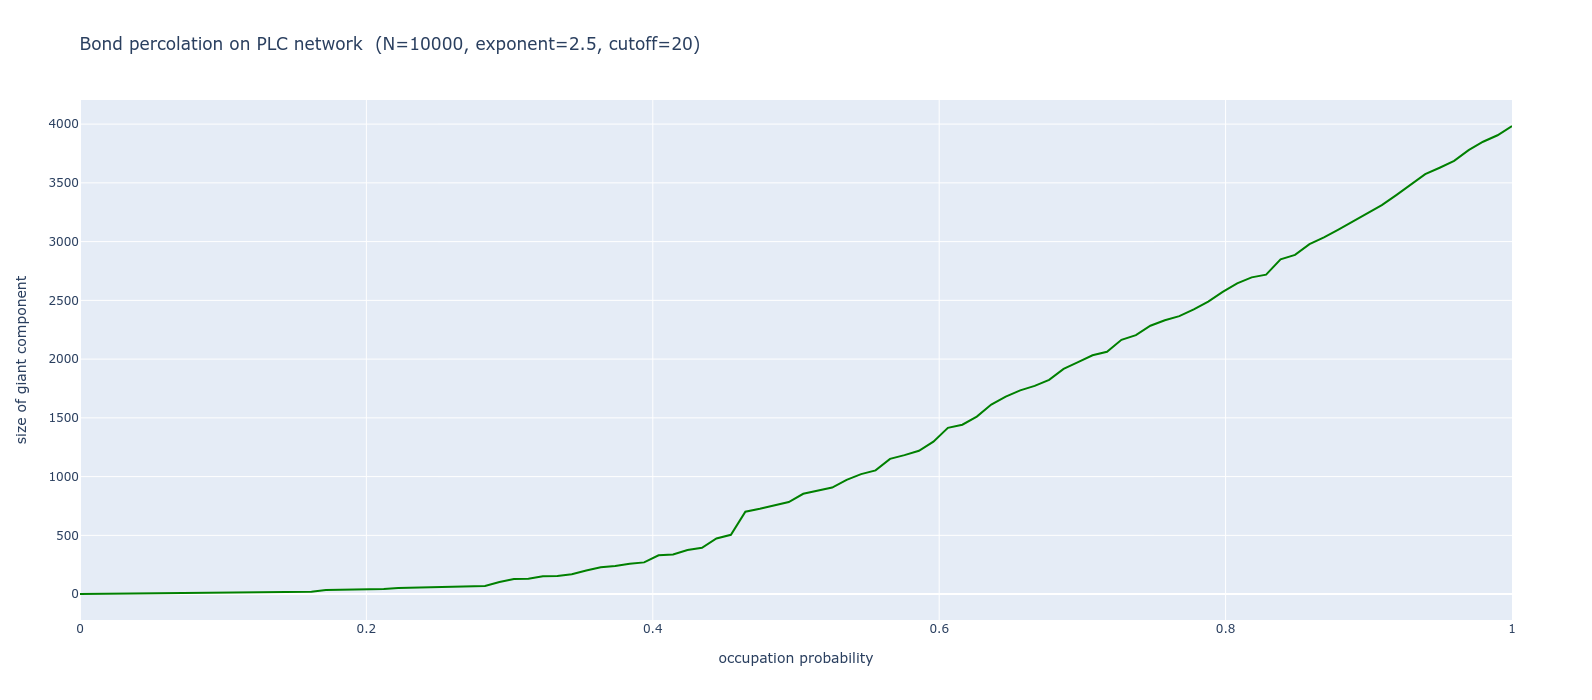

In [66]:
e = BondPercolation(g)
rcs = e.set(params).run()

xs = [rc[Experiment.RESULTS][BondPercolation.P] for rc in rcs]
ys = [rc[Experiment.RESULTS][BondPercolation.GCC] for rc in rcs]

scatter = go.Scatter(x=xs, y=ys,
                     mode='lines', marker=dict(color='green'))
layout = go.Layout(title=f'Bond percolation on PLC network  (N={N}, exponent={alpha}, cutoff={kappa})',
                  xaxis_title='occupation probability',
                  yaxis_title='size of giant component', width=700, height=700)
fig = go.Figure(data=scatter, layout=layout)
fig.show()

## Extending the algorithm to percolate the residual network

The extended Newman-Ziff (ENZ) algorithm operates as a recursive callof NZ on the residual network formed from the party of the base network that has not been occupied by the primary percolation process. 

Suppose we are at some stage of the primary percolation process. We have thus formed $O_T$, the occupied sub-network at some value of $T$. The **residual network** $B_T = G - O_T$ is formed from the edges of $G$ that are unoccupied (and so are not part of $O_T$), and from the nodes that are not incident on any of these edges. $B_T$ forms the base network for the nested application of NZ, and we progressively occupy edges from $B_T$ to form the **residual occupied network** $R_{T'}$, where $T'$ denotes the occupation probability of edges in the residual network.

Each edge in $B_T$ falls into one of two classes:

1. It has both endpoints in $B_T$; or
2. It has one endpoint in $B_T$ and one endpoint in $O_T$.

Edges in the second class form the **boundary** (to take a topological perspective) of $O_T$. They cannot be occupied by NZ operating over $B_T$, since to do so would connect $R_{T'}$ to the GCC of the primary percolation process, $O_T$. ENZ therefore ignores any edge falling into the boundary, and occupies only non-boundary edges.

In [22]:
class ResidualBondPercolation(NewmanZiff):

    # Experimental results
    P_RESIDUAL_STEM : Final[str] = 'epydemic.residualbondpercolation.pOccupied'
    DEPTH_RESIDUAL : Final[str] = 'epydemic.residualbondpercolation.depth'
    N_RESIDUAL : Final[str] = 'epydemic.residualbondpercolation.N'
    M_RESIDUAL : Final[str] = 'epydemic.residualbondpercolation.M'
    GCC_RESIDUAL : Final[str] = 'epydemic.residualbondpercolation.gcc'
        
    @classmethod
    def P_RESIDUAL(cls, depth : int) -> str:
        '''Return the experimental result corresponding to the occupation probability
        at the given depth: 0 for the primary network, 1 for the first residual network,
        and so on.
        
        :param residual: the network depth
        :returns: the experimental result tag'''
        return '{stem}-{l}'.format(stem=cls.P_RESIDUAL_STEM, l=depth)
    
    def __init__(self, g : Graph =None, samples : Union[int, Iterable[float]] =None, residuals =1):
        super(ResidualBondPercolation, self).__init__(g, samples)
        self._residuals = residuals
    
    def setUp(self, params : Dict[str, Any]):
        super(ResidualBondPercolation, self).setUp(params)
        self._networkIndex = 0
        self._parent = 0
        self._phis = dict()
        self._gcc = 1   # initially all nodes are individual components, unconnected by occupied edges
        
        # all nodes are singleton components in the primary network
        N = self.network().order()
        self._components = numpy.full(N, -1, numpy.int32)
        self._networks = numpy.full(N, 1, numpy.int16)
        
    def rootOf(self, n : Node, network : int) -> Optional[Node]:
        np = self._components[n]
        nn = self._networks[n]
        
        # for a node to be available to this percolation process it has
        # to be one of:
        # - an unoccupied element of the base network 0
        # - an occupied element of the network we're currently building
        # - an element of a network that's later than out parent network
        # These last two conditions overlap (we're later than our parent too),
        # but in the third case the node is treated as an unoccupied singleton
        # and not as a member of a component.
        
        if np == -1:
            # node is an unoccupied singleton, move it to our network and return it
            self._networks[n] = network
            return n
        elif nn == network:
            # node is in our network, use it
            if np < 0:
                # node is a component root, return it
                return n
            else:
                # node is an interior node of a component, track it to the root
                r = self.rootOf(np, network)
                #assert(r is not None)
                #assert(self._networks[r] == self._networks[n])
                
                # short-cut to the root
                self._components[n] = r
                
                # return the root
                return r
        elif nn > self._parent:
            # node is in another available network, reset it as a singleton in ours and return
            self._components[n] = -1
            self._networks[n] = network
            return n
        else:
            # node is in a network inaccessible to us, ignore
            return None

    def orderOfNetwork(self, network : int) -> int:
        if network < 1:
            return 0
        else:
            return numpy.count_nonzero(self._networks == network)

    def occupy(self, n : Node, m : Node, network) -> Optional[int]:
        nr = self.rootOf(n, network)
        mr = self.rootOf(m, network)
        if nr is None or mr is None:
            # not a node in the right network, ignore
            return None
        elif mr != nr:
            # nodes are in different components in this network, join them together
            #assert(self._networks[nr] == self._networks[mr])
            return self.join(nr, mr)
        else:
            # nodes are in the same component, do nothing
            #assert(self._networks[nr] == self._networks[mr])
            return None
        
    def join(self, c1 : Node, c2 : Node) -> int:
        # extract the sizes of the compoents
        c1size = -self._components[c1]
        c2size = -self._components[c2]
        
        # join the second component to the first 
        self._components[c2] = c1
        
        # update the size of the first component
        self._components[c1] -= c2size
        
        # update the running GCC size
        csize = c1size + c2size
        self._gcc = max(self._gcc, csize)
        
        # return the size of the new component
        return csize

    def sample(self, p, es, nexti, N, M, depth, network):
        samples = []
        
        # take the sample at this point
        phi = ResidualBondPercolation.P_RESIDUAL(depth)
        res = self._phis.copy()
        res[self.DEPTH_RESIDUAL] = depth
        res[self.N_RESIDUAL] = N
        res[self.M_RESIDUAL] = M
        res[phi] = p
        res[self.GCC_RESIDUAL] = self._gcc
        samples.append(res)
        
        # if we're re-percolating, do that to get more samples
        if depth < self._residuals:
            es_residual = es[nexti:]
            samples.extend(self.repercolate(p, es_residual, depth, network))
        
        return samples

    def repercolate(self, p, es, depth, network):
        phi = ResidualBondPercolation.P_RESIDUAL(depth)
        self._phis[phi] = p
        oldparent = self._parent
        oldgcc = self._gcc
        self._parent = network
        self._gcc = 1
        ss = self.percolate(es, depth + 1)
        del self._phis[phi]
        self._gcc = oldgcc
        self._parent = oldparent        
        return ss
        
    def percolate(self, es, depth):
        N = self.network().order() - self.orderOfNetwork(self._parent)
        M = len(es)
        self._networkIndex += 1
        network = self._networkIndex
        samples = []
        samplePoint = 0

        # take an initial sample if requested
        if self._samples[samplePoint] == 0.0:
            samples.extend(self.sample(self._samples[samplePoint], es, 0, N, M, depth, network))
            samplePoint += 1
            
        # percolate the network
        for i in range(M):
            # if we've collected all the samples we want, bail out
            if samplePoint >= len(self._samples):
                break
                    
            # occupy the edge
            (n, m) = es[i]
            csize = self.occupy(n, m, network)

            # take a sample if this is a sample point
            if  (i + 1) / M >= self._samples[samplePoint]:
                # we're at the closest probability after the requested sample point,
                # so build the sample
                samples.extend(self.sample(self._samples[samplePoint], es, i + 1, N, M, depth, network))
                samplePoint += 1
                    
        return samples

    def do(self, params : Dict[str, Any]) -> List[Dict[str, Any]]:
        '''Perform the bond percolation process.

        :param params: experimental parameters
        :returns: a list of dicts of experimental results'''      
        # extract and shuffle the edges
        g = self.network()
        es = list(g.edges()).copy()
        numpy.random.shuffle(es)
        return self.percolate(es, 0)

We may now run a resiodual percolation experiment by percolating the base network and, for 50 sample points, percolating the residual network at that point, with the residual network also being sampled at 50 points. This results in a nested dataset consisting of the GCC measurement for 50 values of $T$ (the percolation probability in the primary network) and, for each of these, another sequence of 50 GCC measurements for the residual networks.

In [23]:
lab = Lab()
for k in params:
    lab[k] = params[k]
e = ResidualBondPercolation(g, samples=50)
lab.runExperiment(e)

In [24]:
df = lab.dataframe()

In [25]:
ps = df[ResidualBondPercolation.P_RESIDUAL(0)].unique()

We may use this datset to plot the size of the GCC in the primary network, and compare it to the size of the GCC in the corresponding residual network. 

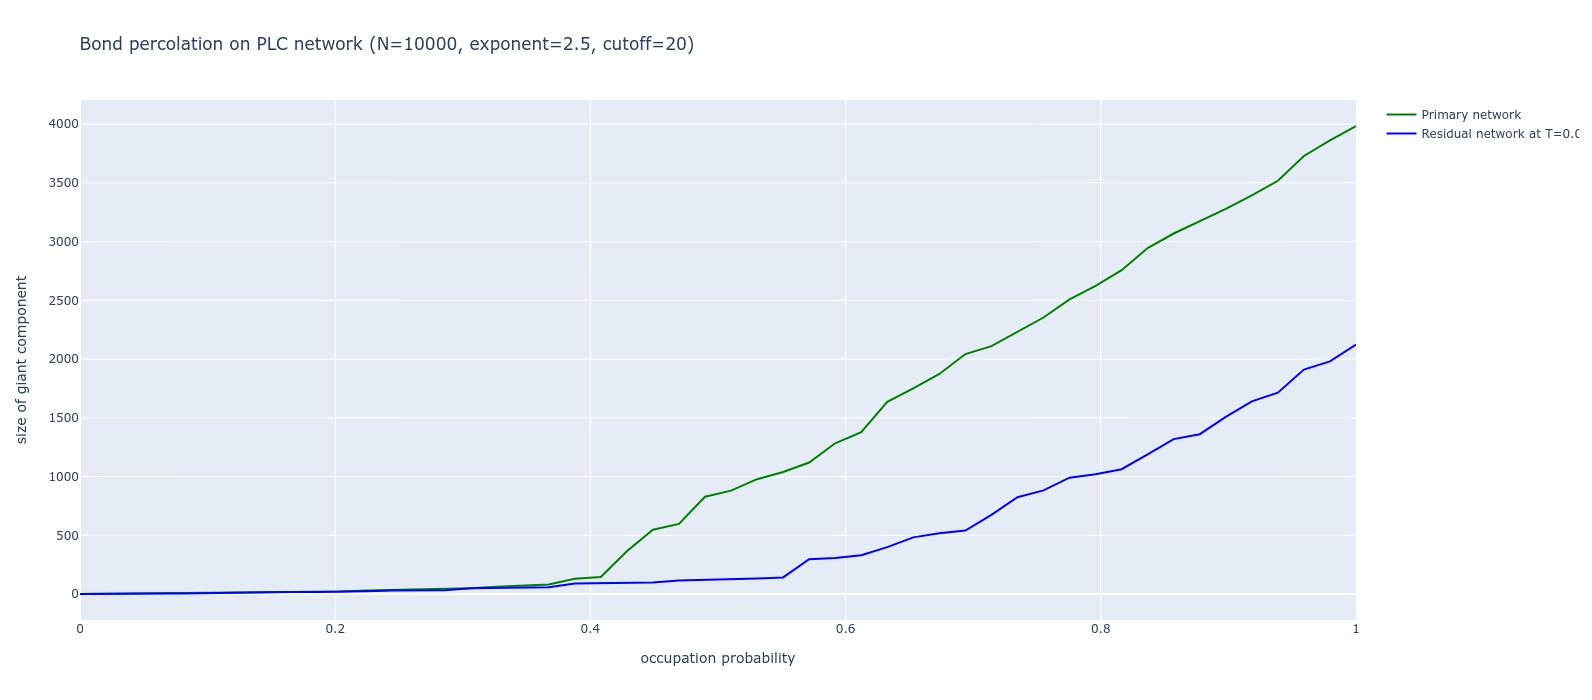

In [65]:
# primary percolation process
basedf = df[df[ResidualBondPercolation.DEPTH_RESIDUAL] == 0]
primary = go.Scatter(x=basedf[ResidualBondPercolation.P_RESIDUAL(0)], y=basedf[ResidualBondPercolation.GCC_RESIDUAL],
                     mode='lines', marker=dict(color='green'),
                     name='Primary network'
                    )

# residual at the chosen point in the primary percolation process
p = ps[2]
basedf = df[df[ResidualBondPercolation.DEPTH_RESIDUAL] == 1]
basedf = basedf[basedf[ResidualBondPercolation.P_RESIDUAL(0)] == p]
residual = go.Scatter(x=basedf[ResidualBondPercolation.P_RESIDUAL(1)], y=basedf[ResidualBondPercolation.GCC_RESIDUAL],
                      mode='lines', marker=dict(color='blue'),
                      name=f'Residual network at T={p:.2f}'
                     )

layout = go.Layout(title=f'Bond percolation on PLC network (N={N}, exponent={alpha}, cutoff={kappa})',
                  xaxis_title='occupation probability',
                  yaxis_title='size of giant component', width=700, height=700)
fig = go.Figure(data=[primary, residual], layout=layout)
fig.show()

We observe that, even for $T = 0.04$ (4% of edges in the base network occupied) the percolation behaviour of the corresponding residual network is very different. We may explore this in more detail by allowing the value of $T$ to be varied and compared to the primary percolation.

In [63]:
app = JupyterDash('residual-percolation-plc')

basedf = df[df[ResidualBondPercolation.DEPTH_RESIDUAL] == 0]
residualdf = df[df[ResidualBondPercolation.DEPTH_RESIDUAL] == 1]
ps = basedf[ResidualBondPercolation.P_RESIDUAL(0)].unique()
maxGcc = df[ResidualBondPercolation.GCC_RESIDUAL].max()
marks = dict()
i = 0
for p in ps:
    marks[p] = f'{p:.2f}' if i % 5 == 0 else ''
    i += 1
    
app.layout = html.Div([
    dcc.Graph(id='residual-percolation-plc-plot'),
    html.Div(['Primary network occupation probability:',
              dcc.Slider(id='residual-percolation-plc-p0',
                         min=0.0,
                         max=1.0,
                         step=None,
                         marks=marks,
                         value=0.0,
                        )
             ]),
    ],
    style=dict(width=1000)
)

@app.callback(
    Output('residual-percolation-plc-plot', 'figure'),
    [Input('residual-percolation-plc-p0', 'value')]
)
def plot_residual(p0):
    pdf=residualdf[residualdf[ResidualBondPercolation.P_RESIDUAL(0)] == p0]
    
    # primary percolation
    primary = go.Scatter(x=ps, y=basedf[ResidualBondPercolation.GCC_RESIDUAL],
                         mode='lines', marker=dict(color='green'),
                         name='Primary network')
    
    # highlight line of where to perform residual percolation
    pPrimary = go.Scatter(x=[p0, p0], y=[0.0, maxGcc],
                          mode='lines', marker=dict(color='salmon'),
                          name=f'Primary network occupation probability {p0:.2f}')
    
    # residual percolation
    residual = go.Scatter(x=pdf[ResidualBondPercolation.P_RESIDUAL(1)], y=pdf[ResidualBondPercolation.GCC_RESIDUAL],
                          mode='lines+markers', marker=dict(color='blue'),
                          name='Residual network')
    
    layout = go.Layout(title=f'Residual network percolation (N={N}, exponent={alpha}, cutoff={kappa})',
                       xaxis_title='occupation probability',
                       yaxis_title='size of GCC',
                       width=1000, height=500)
    fig = go.Figure(data=[primary, pPrimary, residual], layout=layout)
    return fig
            
app.run_server(mode='inline')

This is unexpected. For small values of $T$ there can be very little difference between $G$ and $B_T$, the latter being the former without a small fraction of the edges and the nodes on which they are incident. Nevertheless, it appears that even such a small disruption significantly changes the percolation behaviour.

We hypothesise that the cause of this anomaly is that the first percolation process "fractures" the base network on which the residual percolation occurs, by which we mean that it changes it topology sufficiently to change its percolation threshold. One possible mechanism is indiced by the random selection of edges in the primary percolation. At the early stages (small values of $T$) each edge occupies causes two nodes to be occupied, since it is unlikely that an edge selected at random will be incident on an already-occupied node. Suppose the node at one end of an occupied edge has degree $k$. Since there are more edges incident on a high-degree node than on a low-degree node, an edge chosen at random has a higher probability of being incident on a high-degree node than on a low-degree node. Occupying a node, placing it in $O_T$, means that all other $(k -  1)$ edges incident on it are placed into the boundary of $O_T$ and so become inaccessible to any percolation happening on the residual network. The occupation of high-degree nodes has a small impact on the number of nodes in the residual network, but a considerably larger impact on the number of edges in the residual network, so if high-degree nodes are preferentially occupied the number of residual edges will shrink more slowly than expected, which in turn suppresses the degree distribution of the residual network more dramatically than expected. Whether this hypothesis is accurate needs more research. 